In [1]:
import numpy as np
import time
from sklearn.model_selection import KFold
import pandas as pd
from pdag.data_generator import generate_random_partialB, generate_random_MVN_data
from pdag.pdag import PDAG, _get_partitioned_positions

import networkx as nx
import matplotlib.pyplot as plt




def compute_QPDAG(B, S, lmbda):
    """
    Computes Q_P DAG(B) from equation (2.3) in the provided image.

    Args:
    - B (numpy.ndarray): Estimated matrix from PDAG.
    - S (numpy.ndarray): Covariance matrix of X.
    - lmbda (float): Regularization parameter.

    Returns:
    - QPDAG (float): Score value.
    """
    p = B.shape[0]
    
    # Compute trace(B.T @ B @ S)
    trace_term = np.trace(B.T @ B @ S)
    
    # Compute log|B.T @ B|
    log_det_term = np.log(np.linalg.det(B.T @ B)) if np.linalg.det(B.T @ B) > 0 else 0  # Avoid log(0)

    # Compute regularization term
    l1_term = lmbda * np.sum(np.abs(B[np.triu_indices(p, k=1)]))  # Sum over upper triangular elements |B_ij|

    # Compute full Q_P DAG(B)
    QPDAG = trace_term - log_det_term + l1_term

    return QPDAG

def cross_validate_lambda(X, partitions, lambda_values, k_folds=5, max_itr=100):
    """
    Performs cross-validation to select the optimal lambda for PDAG.

    Args:
    - X (numpy.ndarray): Input dataset.
    - partitions (list): Partition scheme for PDAG.
    - lambda_values (list): Candidate lambda values.
    - k_folds (int): Number of cross-validation folds.
    - max_itr (int): Maximum iterations for PDAG fitting.

    Returns:
    - best_lambda (float): Lambda that minimizes QPDAG.
    - lambda_scores (dict): Cross-validation scores for each lambda.
    """

    if isinstance(X, pd.DataFrame):
        column_names = X.columns.tolist()  # Extract column names if DataFrame
        X = X.values  # Convert to NumPy array
    else:
        column_names = None  # No column names for NumPy arrays
    
    n, p = X.shape
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)  # K-Fold cross-validation
    lambda_scores = {lmbda: [] for lmbda in lambda_values}

    for lmbda in lambda_values:
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]

            # Compute covariance matrix S from training data
            S_train = np.cov(X_train, rowvar=False, bias=True)

            # Fit PDAG model
            pdag = PDAG(partitions=partitions)
            pdag.set_data(X_train, complete_data=True, factor_cols=None)
            B_hat = pdag.fit(lmbda, partitions, max_itr=max_itr)

            # Compute Q_P DAG using B_hat and S_train
            QPDAG_score = compute_QPDAG(B_hat, S_train, lmbda)
            lambda_scores[lmbda].append(QPDAG_score)

    # Compute mean QPDAG for each lambda
    avg_scores = {lmbda: np.mean(scores) for lmbda, scores in lambda_scores.items()}

    # Select the lambda with the lowest QPDAG value
    best_lambda = min(avg_scores, key=avg_scores.get)

    return best_lambda, avg_scores



# best_lambda, scores = cross_validate_lambda(X, partitions, lambda_values, k_folds=5, max_itr=100)
# print(f"Best lambda: {best_lambda}")
# print("Lambda Scores:", scores)

In [2]:
!ls data/

Cows_Imputed.csv              Cows_Observed_Full.xlsx
Cows_Imputed.xlsx             Cows_Observed_No_Missing.csv
Cows_Observed_Full.csv        Cows_Observed_No_Missing.xlsx


In [3]:
data = pd.read_csv('data/Cows_Imputed.csv', sep=';', encoding='latin1')
#data = pd.read_excel('data/Cows_Imputed.xlsx', sheet_name=0)

In [4]:
data.columns

Index(['ID', 'Herd', 'BW', 'WW', 'W16M', 'W24M', 'FCA', 'ACI', 'AVEW240',
       'Long'],
      dtype='object')

In [5]:
""" order data by 

Group 1: BW 1 
Group 2: WW 2
Group 3: W16M 3 
Group 4: W24M 4
Group 5: FCA, ACI 6
Group 6: AVEW40, Long 8

"""

data = data[['BW', 'WW', 'W16M', 'W24M', 'FCA', 'ACI', 'AVEW240', 'Long']]

In [6]:
pdag = PDAG(
    partitions=[1,2,3,4,6],  # Pass partitions as a list
    non_active=False,  # Set to True if needed
    complete_data=True,  # Fill missing data
    factor_cols=None,  # Specify categorical variables if necessary
    max_em_iter=50,  # Max iterations for EM algorithm
    em_tol=1e-6,  # Convergence threshold
    robust=True  # Use robust estimation if required
)

# Ensure data is set before fitting
pdag.set_data(data, complete_data=True, factor_cols=None)

# First run to trigger compilation
Bhat = pdag.fit(0.3, [1,2,3,4,6], max_itr=1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
best_lambda, scores = cross_validate_lambda(data, 
                                            [1,2,3,4,6], 
                                            [0.001, 0.01, 0.05, 0.1, 0.3, 0.5], 
                                            k_folds=5, 
                                            max_itr=100)
print(f"Best lambda: {best_lambda}")
print("Lambda Scores:", scores)

Best lambda: 0.001
Lambda Scores: {0.001: 1190529.5682681939, 0.01: 1190580.8819321855, 0.05: 1190809.054663382, 0.1: 1190967.976276233, 0.3: 1191000.592424217, 0.5: 1191000.592424217}


In [10]:
# Now measure execution time
start = time.time()
Bhat = pdag.fit(0.001, [1,2,3,4,6], max_itr=100)
end = time.time()

print("Elapsed (after compilation) =", end - start)

Elapsed (after compilation) = 0.0030517578125


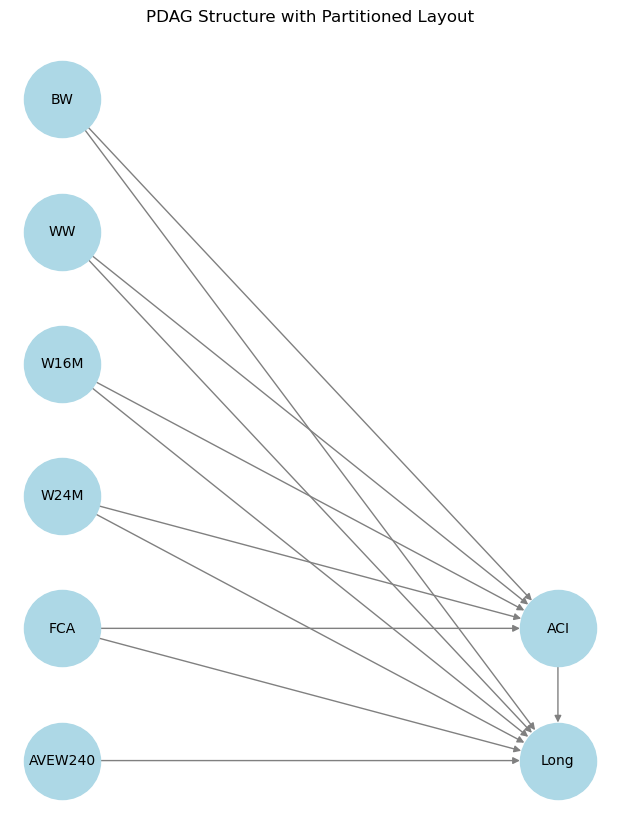

In [11]:
pdag.plotGraph()